In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from libs import libs
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# 1. Load dataset

In [2]:
data_dir = "dataset/heart.csv"
dataset = pd.read_csv(data_dir)

print("dataset shape: {}".format(dataset.shape))

dataset shape: (303, 14)


# 2. Split train test

In [3]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_set = pd.DataFrame(train_set.values, columns=train_set.columns)
test_set = pd.DataFrame(test_set.values, columns=test_set.columns)

print("train_set: {}".format(train_set.shape))
print("test_set: {}".format(test_set.shape))

train_set: (242, 14)
test_set: (61, 14)


# 3. Preprocessing data

## 3.1 Numerical

In [4]:
numerical_columns = ["age", "trestbps", "chol", "thalach", "oldpeak"]

train_numerical_set = train_set[numerical_columns]

std_scaler = StandardScaler()
std_scaler.fit(train_numerical_set)
train_set_normalized = std_scaler.transform(train_numerical_set)

train_set_normalized = pd.DataFrame(train_set_normalized, columns=numerical_columns)

## 3.2 Categorical

### 3.2.1 Binary

In [5]:
binary_columns = ["exang", "fbs", "sex", "target"]

train_binary_set = train_set[binary_columns]

### 3.2.2 Multi class

In [6]:
multiclass_columns = ["cp", "restecg", "slope", "ca", "thal"]

train_multiclass_set = train_set[multiclass_columns]

encoder = OneHotEncoder(categories="auto")
encoder.fit(train_multiclass_set)
train_set_encoded = encoder.transform(train_multiclass_set)

train_set_encoded = pd.DataFrame(train_set_encoded.toarray(), columns=encoder.get_feature_names(multiclass_columns))

## 3.3 Merge

In [7]:
train_set_processed = pd.concat([train_set_normalized, train_binary_set, train_set_encoded], axis=1)

y_train = train_set_processed["target"]
x_train = train_set_processed.drop(["target"], axis=1)

# 4. Get default accuracy

In [8]:
# Fit logistic regression model to dataset without using regularization
logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
score = cross_val_score(logis_reg, x_train, y_train, cv=5, scoring="accuracy")
R_squared = libs.R_squared(x_train, y_train)
print("Cross validation accuracies: {}".format(score))
print("Accuracy mean: {:.2f}%".format(np.mean(score) * 100))
print("R_sqaured: {:.2f}%".format(R_squared * 100))

Cross validation accuracies: [0.79591837 0.89795918 0.79591837 0.91666667 0.78723404]
Accuracy mean: 83.87%
R_sqaured: 58.36%


# 5. Removing collinearity

In [19]:
# Implement function to calculate TSS
def TSS(y):
    return np.sum(np.square(y - np.mean(y)))

# Implement function to calculate RSS
def RSS(y, y_hat):
    return np.sum(np.square(y - y_hat))

# Implement function to calculate R_squared
def R_square(y, y_hat):
    return 1 - RSS(y, y_hat) / TSS(y)

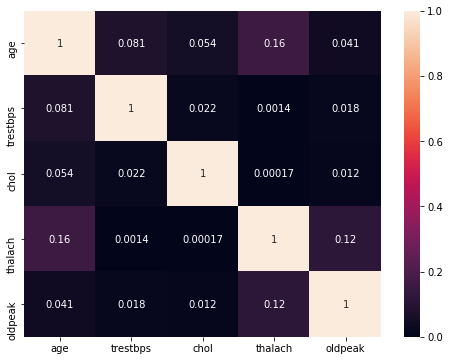

In [21]:
x_train_numerical = x_train.iloc[:, 0:5]
numerical_columns = x_train_numerical.columns.values
R_squared_matrix = [[0 for i in range(len(numerical_columns))] for j in range(len(numerical_columns))]

# Regression each feature to others features and calculate R_squared,
# to see if one feature can explain another feature quite well, therefore, they are consider collinearity.
for i in range(len(numerical_columns)):
    for j in range(len(numerical_columns)):
        x = x_train_numerical[numerical_columns[i]].values.reshape(-1, 1)
        y = x_train_numerical[numerical_columns[j]].values
        # Regression one feature to another
        linear_reg = LinearRegression()
        linear_reg.fit(x, y)
        y_hat = linear_reg.predict(x)
        # Calculate R_squared
        R_squared = R_square(y, y_hat)
        R_squared_matrix[i][j] = R_squared
        
R_squared_matrix = pd.DataFrame(R_squared_matrix, columns=numerical_columns)
R_squared_matrix.rename(index={i: name for i, name in enumerate(numerical_columns)}, inplace=True)
plt.subplots(figsize=(8, 6))
sns.heatmap(R_squared_matrix, annot=True)
plt.show()

### There is no collinearity in numerical predictors.

# 6. F-test
\begin{equation}
F = \frac{(LSS(overall) - LSS(fit)) / p}{LSS(fit) / (n - p - 1)}
\tag{1}
\end{equation}

\begin{equation}
LSS(fit) = \sum_{i=1}^{n} y_i*log(\hat{y_i}) + (1 - y_i)*log(1 - \hat{y_i})
\tag{2}
\end{equation}

\begin{equation}
LSS(overall) = \sum_{i=1}^{n} y_i*log(\frac{len(where(y_i == 1))}{len(y_i)}) + (1 - y_i)*log(1 - \frac{len(where(y_i == 1))}{len(y_i)})
\tag{3}
\end{equation}

When  
n: is numbers of observation    
p: is numbers of predictor

In [10]:
libs.F_test(x_train, y_train)

LSS_overall: -166.55
LSS_fit: -69.36
F-test score is 11.11, that is more than 5, therefore, there is relationship between predictors and response.


### From the result of F-test above, F-statistic value is more than 1, hence this indicate that there is relationship between predictors and response.

# 7. Feature selection

## 7.1 Using Tree's feature important

In [11]:
# Get best parameter for random forst model
param_grid = {"n_estimators": list(range(10, 100, 2))}
forest_clf = RandomForestClassifier(random_state=42)

clf = GridSearchCV(forest_clf, param_grid, cv=5)
clf.fit(x_train, y_train)
print("Best param: {}".format(clf.best_params_))
print("Best score: {}".format(clf.best_score_))

Best param: {'n_estimators': 14}
Best score: 0.8388429752066116


C:\Users\Acer\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


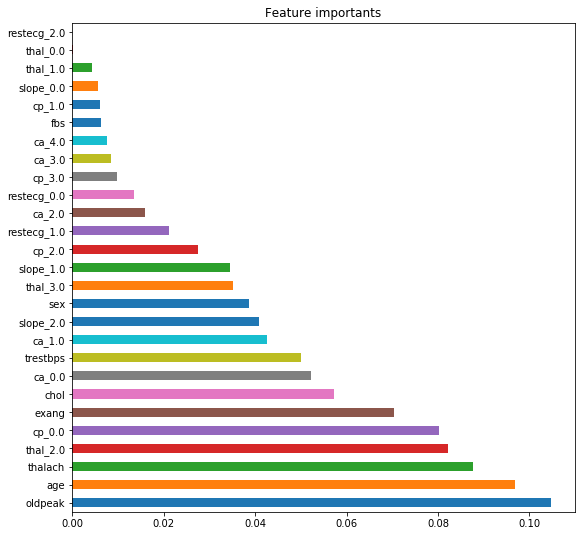

In [18]:
# Get important festures
feature_importants = pd.Series(clf.best_estimator_.feature_importances_, index=x_train.columns)
feature_importants_sorted = feature_importants.sort_values(ascending=False)
feature_importants_sorted.plot(kind="barh", figsize=(9, 9))
plt.title("Feature importants")
plt.show()

In [22]:
# Drop 0% important features
important_score = 0.0
features_name = []
for column in feature_importants_sorted.index:
    important_score += feature_importants_sorted.loc[column]
    if important_score >= 1.0:
        break
    else:
        features_name.append(column)

new_x_train = x_train.loc[:, features_name]

# Fit linear regression model with only important features
logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
score = cross_val_score(logis_reg, new_x_train, y_train, cv=5, scoring="accuracy")
R_squared = libs.R_squared(new_x_train, y_train)
print("Cross validation accuracies: {}".format(score))
print("Accuracy mean: {:.2f}%".format(np.mean(score) * 100))
print("R_sqaured: {:.2f}%".format(R_squared * 100))

Cross validation accuracies: [0.81632653 0.89795918 0.79591837 0.91666667 0.78723404]
Accuracy mean: 84.28%
R_sqaured: 58.36%


## 7.2 Using Subset selection

### 7.2.1 Best subset selection

### 7.2.2 Forward stepwise selection

In [77]:
def forward_selection(x, y):
    # Add best feature that provide best R^2 value to the model one at a time,
    # and remember each batch of features from p=1 to P (P: number of all features)
    features = list(x.columns.values)
    best_features_batchs = {"0": []}
    max_R_squared_batchs = {"0": 0}
    
    number_of_features = x.shape[1]
    for p in range(1, number_of_features + 1):
        max_R_squared_feature = None
        for candidate_feature in features:
            if len(best_features_batchs) == 0:
                try_features = [candidate_feature]
            else:
                # Add candidate feature to the last best_batch_features
                try_features = best_features_batchs[str(p - 1)] + [candidate_feature]
                
            try_x = x[try_features].values
            if try_x.ndim == 1:
                try_x = try_x.reshape(-1, 1)
            
            # Calculate R^2
            logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
            logis_reg.fit(try_x, y)
            y_hat = logis_reg.predict(try_x)
            R_squared = R_square(y, y_hat)
            
            # Get maximum R^2 feature
            if R_squared > max_R_squared_batchs[str(p - 1)]:
                max_R_squared = R_squared
                max_R_squared_feature = candidate_feature
        
        # If there is no more improve then stop it
        print("Improvement: {}".format(max_R_squared - max_batch_R_squared[str(p - 1)]))
        if max_R_squared > 0:
            # Remove maximum R^2 feature from features list
            features.remove(max_R_squared_feature)
            # Remember current best batch feature
            best_features_batchs[str(p)] = best_features_batchs[str(p - 1)] + [max_R_squared_feature]
            max_R_squared_batchs[str(p)] = max_R_squared
            print(best_features_batchs[str(p)])
            print(max_R_squared_batchs[str(p)])
            print("-------------------------")
        else:
            break

In [78]:
batch_features = forward_selection(x_train, y_train)

Improvement: 0.015106573773884358
['thal_2.0']
0.015106573773884358
-------------------------
Improvement: 0.08346554459543354
['thal_2.0', 'oldpeak']
0.0985721183693179
-------------------------
Improvement: 0.11685176243360684
['thal_2.0', 'oldpeak', 'ca_0.0']
0.21542388080292474
-------------------------
Improvement: 0.13354487135269366
['thal_2.0', 'oldpeak', 'ca_0.0', 'cp_0.0']
0.3489687521556184
-------------------------
Improvement: 0.08346554459543354
['thal_2.0', 'oldpeak', 'ca_0.0', 'cp_0.0', 'exang']
0.43243429675105194
-------------------------
Improvement: 0.0
['thal_2.0', 'oldpeak', 'ca_0.0', 'cp_0.0', 'exang', 'age']
0.43243429675105194
-------------------------
Improvement: 0.016693108919086708
['thal_2.0', 'oldpeak', 'ca_0.0', 'cp_0.0', 'exang', 'age', 'sex']
0.44912740567013865
-------------------------
Improvement: 0.016693108919086708
['thal_2.0', 'oldpeak', 'ca_0.0', 'cp_0.0', 'exang', 'age', 'sex', 'trestbps']
0.46582051458922535
-------------------------
Improvem

In [22]:
features = list(x_train.columns.values)
selected_features = []
max_score_features = []

while(1):
    max_R_squared = 0
    max_R_squared_feature = None
    # For loop for all feature that left
    for feature in features:
        # Assemble features to feed to model
        try_features = selected_features + [feature]
        # Calculate R^2
        logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
        logis_reg.fit(x_train[try_features], y_train)
        y_hat = logis_reg.predict(x_train[try_features])
        R_squared = R_square(y_train, y_hat)
        # Get maximum R^2 feature
        if R_squared > max_R_squared:
            max_R_squared = R_squared
            max_R_squared_feature = feature

    if max_R_squared > 0:
        # Remove maximum R^2 feature from features list
        features.remove(max_R_squared_feature)
        # Append maximum R^2 feature to selected feature list
        selected_features.append(max_R_squared_feature)
        # Add selected features to max_score_features
        max_score_features.append(selected_features.copy())
    else:
        break

Accuracy mean: 85.53%
Number of features: 9
Best features: ['thal_2.0', 'oldpeak', 'ca_0.0', 'cp_0.0', 'exang', 'age', 'sex', 'trestbps', 'slope_0.0']


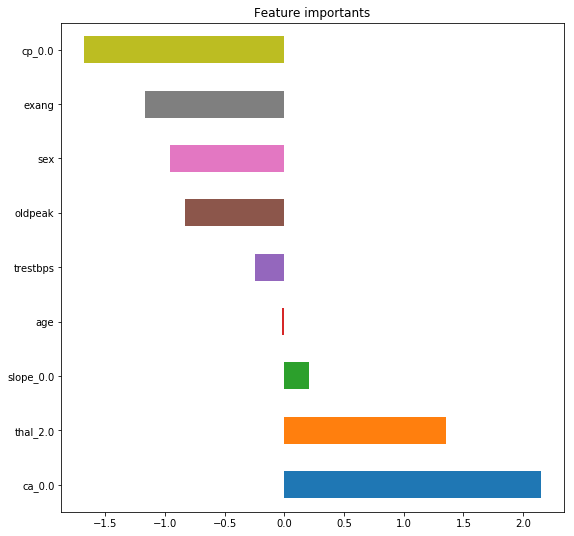

In [27]:
# Get cross validation score for each batch of features
best_features = None
best_score = 0
for features in max_score_features:
    new_x_train = x_train.loc[:, features]
    
    logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
    score = cross_val_score(logis_reg, new_x_train, y_train, cv=10, scoring="accuracy")
    
    logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
    logis_reg.fit(new_x_train, y_train)
    y_hat = logis_reg.predict(new_x_train)
    R_squared = R_square(y_train, y_hat)
    
    if np.mean(score) > best_score:
        best_score = np.mean(score)
        best_features = features
        
print("Accuracy mean: {:.2f}%".format(best_score * 100))
print("Number of features: {}".format(len(best_features)))
print("Best features: {}".format(best_features))

# Show important festures
logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
logis_reg.fit(x_train[best_features], y_train)

feature_importants = pd.Series(logis_reg.coef_.ravel(), index=x_train[best_features].columns)
feature_importants_sorted = feature_importants.sort_values(ascending=False)
feature_importants_sorted.plot(kind="barh", figsize=(9, 9))
plt.title("Feature importants")
plt.show()

### 7.2.3 Backward stepwise selection

### 7.2.4 Hybrid appoaches

## 7.3 Using l1 regularization

In [69]:
# Get best parameter for random forst model
param_grid = {"C": list(range(1, 100, 1))}
logis_reg = LogisticRegression(penalty="l1" ,solver="saga", max_iter=100000)

clf = GridSearchCV(logis_reg, param_grid, cv=5)
clf.fit(x_train, y_train)
print("Best param: {}".format(clf.best_params_))
print("Best score: {}".format(clf.best_score_))

Best param: {'C': 4}
Best score: 0.8429752066115702


C:\Users\Acer\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


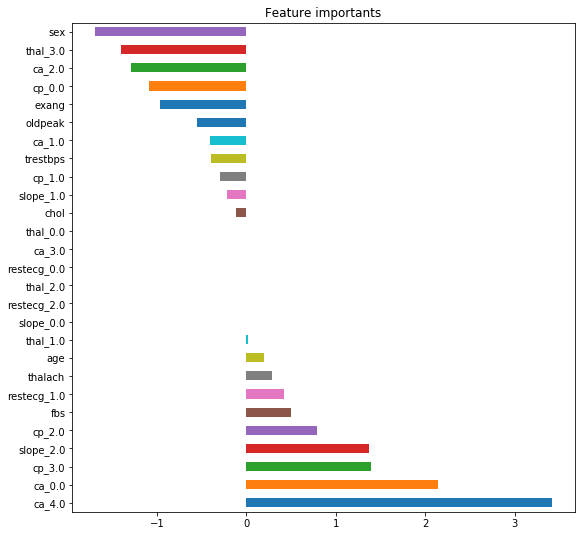

In [70]:
logis_reg = LogisticRegression(penalty="l1" ,solver="saga", C=4, max_iter=1000)
logis_reg.fit(x_train, y_train)

# Get important festures
feature_importants = pd.Series(logis_reg.coef_.reshape(27), index=x_train.columns)
feature_importants_sorted = feature_importants.sort_values(ascending=False)
feature_importants_sorted.plot(kind="barh", figsize=(9, 9))
plt.title("Feature importants")
plt.show()

In [68]:
[x_train.columns[index] for index in np.where(feature_importants == 0)[0]]

['restecg_0.0', 'restecg_2.0', 'slope_0.0', 'ca_3.0', 'thal_0.0', 'thal_2.0']

In [71]:
[x_train.columns[index] for index in np.where(feature_importants == 0)[0]]

['restecg_0.0', 'restecg_2.0', 'slope_0.0', 'ca_3.0', 'thal_0.0', 'thal_2.0']